In [4]:
# Load the required packages
# import pandas as pd
import numpy as np
import SpringRank as sr
# from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def compute_gamma(A, beta):
    
    # ignore some warning messages surfaced by SpringRank
    np.seterr(divide='ignore', invalid='ignore') 
    
    # compute springranks
    phi = sr.get_ranks(A)
    
    # exponentiate
    gamma = np.exp(beta * phi)
    
    # normalize
    gamma = gamma / gamma.sum()
    
    return(gamma)    

In [6]:

# construct the initial condition and container for trajectories
def initialize(n, n_rounds = 1, A0 = None):
    if A0 is None:
        A = np.ones((n, n)).astype(int)
    else:
        A = A0
    GAMMA = np.zeros((n_rounds, n))
    
    return(A, GAMMA)
    
# construct the increment to add to the current state. Either stochastic or deterministic. 
def increment(n, gamma, method = 'stochastic'):
    
    if method == 'stochastic':
        j = np.random.randint(n)           # uniformly random department gets to hire
        i = np.random.choice(n, p = gamma) # chooses from departments proportional to $\gamma$. 
        E = np.zeros((n,n))
        E[i,j] = 1
        return(E)
    
    elif method == 'deterministic': 
        G = np.tile(gamma, (n,1)).T        # G is the expectation of E above 
        return(G)
    
def simulate(n, beta, lam, n_rounds, method = 'stochastic', update_interval = 1, A0 = None, ranked = False):
    A, GAMMA = initialize(n, n_rounds, A0)
    
    for r in range(n_rounds):          
        if r % update_interval == 0:                    # update the springranks at this interval
            gamma = compute_gamma(A, beta)
        if ranked:     
            GAMMA[r,:] = gamma[np.argsort(gamma)]                              # record current gamma, SORTED
        else:
            GAMMA[r,:] = gamma
        A = lam*A + (1-lam)*increment(n, gamma, method) # update A
        
    return(GAMMA)

def rank_experiment(**kwargs):
    GAMMA = simulate(**kwargs)
    rank_means = GAMMA[np.int(GAMMA.shape[0]/2):,].mean(axis = 0)
    return(rank_means)

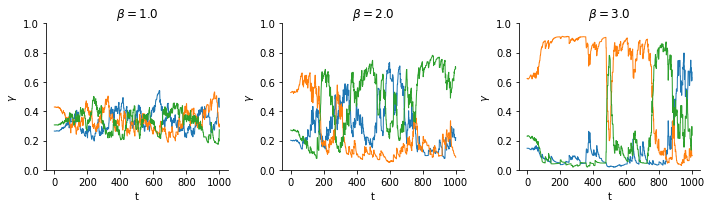

In [24]:
m_plots = 3 # this many columns of plots

betas = np.linspace(1, 3, m_plots) # evenly spaced values of $\beta$ between 1 and 3
n = 3                              # this many departments
lam = .95                          # memory param
n_rounds = 1000                    # simulation length

A0 = np.random.randint(low = 1, high = 10, size = (n,n))                # asymmetric initial condition
# A0[0,1] += 5
    
methods = ['stochastic'] # use both methods    

# create fig and axes
fig, axarr = plt.subplots(1,m_plots, figsize = (10, 3))

for i in range(m_plots):

    # do the simulation
    v = simulate(n = n, 
                 beta = betas[i], 
                 lam = lam, 
                 n_rounds = n_rounds, 
                 update_interval = 1, 
                 A0 = A0, 
                 method = 'stochastic')

    for j in range(n):
        axarr[i].plot(v[:,j], alpha = 1, linewidth = 1)

        # axis labels and aesthetics
    axarr[i].set(
                 ylim = (0,1),
                 title = r'$\beta = $' + str(betas[i]),
                 xlabel = 't',
                 ylabel = r'$\gamma$')

    axarr[i].spines['right'].set_visible(False)
    axarr[i].spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('fig/traces.png', dpi = 300)

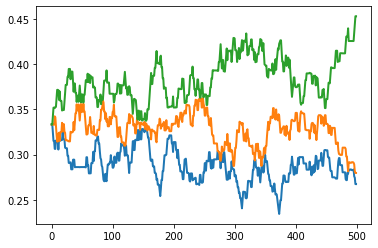

In [25]:
n = 3

A0 = np.ones((n,n))
# A0 = np.random.randint(low = 1, high = 10, size = (n,n))
A0 = A0 / A0.sum()
# A0 = A0.astype(int)

n_rounds = 500

GAMMA = simulate(n = n, 
                 beta = 1.9, 
                 lam = .99, 
                 n_rounds = n_rounds, 
                 method = 'stochastic', 
                 update_interval = 1,
                 A0 = A0, 
                 ranked = True)

for i in range(n):
    plt.plot(GAMMA[:,i], linewidth = 2)

In [30]:
def rank_experiment_suite(n, n_rounds, n_epochs, update_interval, lam, BETAS):

    R = np.zeros((n_epochs, len(BETAS), n))

    for j in range(n_epochs):
        for i in range(len(BETAS)):
            R[j,i] = rank_experiment(n = n, 
                             beta = BETAS[i], 
                             lam = lam, 
                             n_rounds = n_rounds, 
                             method = 'stochastic', 
                             update_interval = update_interval,
        #                      A0 = A0, 
                             ranked = True)
            
    return(R.mean(axis = 0))

In [35]:
R.shape

(5, 21, 3)

In [85]:
# computation for order parameter viz, may take a while

BETAS = np.linspace(1, 3, 51)
n = 3
n_rounds = 10000
n_epochs = 20
update_interval = 10
LAMBDA = [.9, 0.99, 0.995, 0.999]

R_ = {lam: rank_experiment_suite(n, n_rounds, n_epochs, update_interval, lam, BETAS) for lam in LAMBDA}

In [88]:
import pickle
with open('fig/order_parameter.pickle', 'wb') as f:
    pickle.dump(R_, f)
    
with open('fig/order_parameter.pickle', 'rb') as f:
    R_ = pickle.load(f)

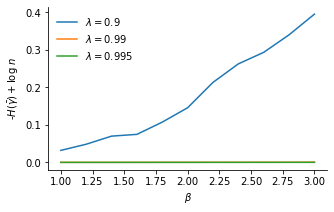

In [106]:
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)

def entropy(R):
    return((-R*np.log(R)).sum(axis = 1))

for lam in LAMBDA:
    ax.plot(BETAS, -entropy(R_[lam]) + np.log(3), label = r'$\lambda = $' + str(lam))
      
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)

plt.legend(frameon = False)

ax.set(xlabel = r'$\beta$',
       ylabel = r'-$H(\bar{\gamma}) + \log \;n$')

plt.savefig('fig/order_parameter.png', dpi = 300)